In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import os
from time import time

In [2]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from GetAgentData import *

A latent diffusion model takes three primary steps
<ol>
    <li>An auto encoder to reduce the dimensionality of the input space and a decoder to upscale the reduced dimensionality back to its true scale.</li>
    <li>An image denoising model. Idealy this will learn to denoise the encoded space. By using cross attention, a second key vector can guide the denoising process</li>
    <li>Finally a preprocessing layer to encode the key vector that will be used for denoising.</li>
</ol>

The auto encoder is trival to train. Give it all data points and let it encode then decode the images.

The text preprocessor is less clear how this will work with our problem statement. Ideally we do not need one as our problem statement is finite thus may only require light preprocessing.

The image denoiser is the complicated part. From what I can find the image denoiser will be a modified U-net with cross atention layers before each downsample and at each concatenation.


The image auto encoder is simple enough to create and train. just train on the image dataset to create an encoder and decoder. We will then use the encoded latent space for all denoising steps.

In [4]:
#overview of the data
#dataDirectory = os.path.join(os.getcwd(),'data')
dataDirectory = r"E:\TopoptGAfileSaves\ComplianceMinimization\Agents"
DATA_FILE_PATH = os.path.join(dataDirectory,'100_50')

dir_list = os.listdir(DATA_FILE_PATH)
max_data_points = len(dir_list)
print("Number of data points: {}".format(len(dir_list)))
print(dir_list[0])



Number of data points: 3129
Agent1_485135


In [5]:
class TopOptSequence:
    def __init__(self,ID,forces,dof,passive,x,numIterations):
        self.ID = ID
        self.forceImage = forces
        self.anchorImage = dof
        self.filledAreaImage = passive
        self.xPhys_array = x
        self.numIterations = numIterations
        self.iterationJumpTracker = []
    
    def dispenceData(self,iterationJump:int=5):
        """
        When called creates list of numpy arrays filled with the data needed to train the model

        returns:
            forces_array
            support_array
            filled_array
            x_array
            x_optimized_array
            finished_array
        """
        dataX = []
        dataY = []
        self.iterationJumpTracker = []
        for j in range(self.numIterations-iterationJump):
                dataX.append([self.forceImage.copy(),self.anchorImage.copy(),self.filledAreaImage.copy(),self.xPhys_array[:,:,j]])
                v = 0.0
                f= 'unfinished'
                if(j+iterationJump >= self.numIterations - 1):
                    v = 1.0
                    f = 'finished'
                dataY.append([self.xPhys_array[:,:,j+iterationJump],np.array([v])])
                self.iterationJumpTracker.append([j,j+iterationJump])

                #print("Adding itter: {} -> {}:{}".format(j,j+iterationJump,f))

        for j in range(1,min(iterationJump,self.numIterations)):
            # add the last iterations(dataY has True)
            dataX.append([self.forceImage.copy(),self.anchorImage.copy(),self.filledAreaImage.copy(),self.xPhys_array[:,:,-j -1]])
            dataY.append([self.xPhys_array[:,:,self.numIterations-1],np.array([1.])])
            self.iterationJumpTracker.append([-j,self.numIterations-1])

            #print("Adding itter: {} -> {}:finished".format(numIterations-j-1,numIterations-1))

        # add the optimal Stoping point data, input = output
        dataX.append([self.forceImage.copy(),self.anchorImage.copy(),self.filledAreaImage.copy(),self.xPhys_array[:,:,self.numIterations-1]])
        dataY.append([self.xPhys_array[:,:,self.numIterations-1],np.array([1.])])
        self.iterationJumpTracker.append([self.numIterations-1,self.numIterations-1])


        forces_array = []
        support_array = []
        filled_array = []
        x_array = []
        for forces,support,filled,x in dataX:

            forces_array.append(forces)
            support_array.append(support)
            filled_array.append(filled)
            x_array.append(x)

        x_optimized_array = []
        finished_array = []
        for x,finished in dataY:
            x_optimized_array.append(x)
            finished_array.append(finished)


        return forces_array,support_array,filled_array,x_array,x_optimized_array,finished_array

    def findNextIterations(self,i):
        """
        Given and index for a predicted image, find it's next optimized output.
        each output image will have a order that matches the order of it's input.
        By knowing the input image we can find what image the prediction was supposed to be.
        By knowing what the image was supposed to be, we can find next step in the iteration.


        Process works like this:
            - iterationTracker stores the input and output image,
            - We know the input image so we use this to find the correct output image
            - We then search the tracker for where the output image was used as input to get the correct next iteration.
        """
        def searchTracker(index):
            """given an input index find the matching output index"""
            for inputIndex,outputIndex in self.iterationJumpTracker:
                if(inputIndex == index):
                    return outputIndex
            return -1
        
        correctOutput = searchTracker(i)
        nextIteration = searchTracker(correctOutput)
        return nextIteration

    def formatPredictedData(self,predicted_x_array):
        """
        Given an array of images and the finished array, reformate the images with their respective inputs to create a new dataset that has as input the predicted x and as output the correct next iteration.

        The iteration Jump tracker has stored what iterations were jumped so by following the tracker list we can find the correct next output
        """

        n = len(predicted_x_array)
        if(n ==  self.numIterations):#check if correct number of iterations has been recieved
            forces_array = []
            support_array = []
            filled_array = []
            x_array = []
            x_optimized_array = []
            finished_array = []
            for i in range(n):
                correctOutput = self.findNextIterations(i)
                if(correctOutput <= 0):
                    continue
                else:
                    forces_array.append(self.forceImage.copy())
                    support_array.append(self.anchorImage.copy())
                    filled_array.append(self.filledAreaImage.copy())

                    x_array.append(predicted_x_array[i].copy())
                    v = 0.0
                    if(correctOutput >= n):
                        correctOutput = n-1
                        v = 1.0
                    x_optimized_array.append(self.xPhys_array[:,:,correctOutput])
                    finished_array.append([v])
                    
            return forces_array,support_array,filled_array,x_array,x_optimized_array,finished_array

        else:
            raise Exception("Data given is not of the correct format. required iterations: {}. iterations recieved: {}".format(self.numIterations,n))

    def dispenceFirstIterationData(self):
        dataX = []
        dataY = []
        
        dataX.append([self.forceImage.copy(),self.anchorImage.copy(),self.filledAreaImage.copy(),self.xPhys_array[:,:,0]])
        dataY.append([self.xPhys_array[:,:,1],np.array([0])])

        dataX.append([self.forceImage.copy(),self.anchorImage.copy(),self.filledAreaImage.copy(),self.xPhys_array[:,:,0]])
        dataY.append([self.xPhys_array[:,:,2],np.array([0])])

        forces_array = []
        support_array = []
        filled_array = []
        x_array = []
        for forces,support,filled,x in dataX:

            forces_array.append(forces)
            support_array.append(support)
            filled_array.append(filled)
            x_array.append(x)

        x_optimized_array = []
        finished_array = []
        for x,finished in dataY:
            x_optimized_array.append(x)
            finished_array.append(finished)


        return forces_array,support_array,filled_array,x_array,x_optimized_array,finished_array
        
    def dispenceM7modelData(self,iterationJump:int=5,predictionDepth:int=5):
        """
        When called creates list of numpy arrays filled with the data needed to train the model
        Designed to return the inital input but with an array of output representing the folowing iterations.

        This will allow the model to train on its own predictions
        """
        dataX = []
        dataY = []
        for j in range(self.numIterations-(iterationJump//2)):
            dataX.append([self.forceImage.copy(),self.anchorImage.copy(),self.filledAreaImage.copy(),self.xPhys_array[:,:,j]])
            
            dataY.append([])
            for i in range(predictionDepth):
                currentIteration = min(j + i*iterationJump,self.numIterations-1)
                v = 0.0
                if(currentIteration >= self.numIterations - 1):
                    v = 1.0
                dataY[j].append([self.xPhys_array[:,:,currentIteration],np.array([v])])


        forces_array = []
        support_array = []
        filled_array = []
        x_array = []
        for forces,support,filled,x in dataX:

            forces_array.append(forces)
            support_array.append(support)
            filled_array.append(filled)
            x_array.append(x)

        x_optimized_array = []
        finished_array = []
        for i in range(len(dataY)):
            x_optimized_array.append([])
            finished_array.append([])
            for x,finished in dataY[i]:
                x_optimized_array[i].append(x)
                finished_array[i].append(finished)


        return forces_array,support_array,filled_array,x_array,x_optimized_array,finished_array

    def dispenceIterationsOnly(self):
        x_array = []
        for i in range(self.numIterations):
            x_array.append(self.xPhys_array[:,:,i])
            
        return x_array
 


In [6]:
def buildDataSet(dataPointsToGrab:int):

    # Constants of interest
    # DATA_FILE_PATH = path to agent files
    # dir_List = all agent files
    # max_data_points = total number of datapoints

    dataPointsToGrab = min(dataPointsToGrab,max_data_points)

    #randomize the data grabed so that the first thee datapoints aren't always in the data.
    indexList = np.arange(max_data_points,dtype='int32')
    np.random.shuffle(indexList)

    sequenceData = []
    print("Retreiving {} Datapoints.".format(dataPointsToGrab))

    for i in range(dataPointsToGrab):
        print("{:.2f}%\t\t".format((100*(i/dataPointsToGrab))),end='\r')
        try:
            #join the data file path to a random sorted member within the data directory
            pathToAgent = os.path.join(DATA_FILE_PATH,dir_list[indexList[i]])
            forces,dof,passive,x,numIterations = formatIterativeModelDataSet(pathToAgent)
        except:
            #if an exception occurs list it and move forward
            print("Exception Occured at file '{}'.".format(os.path.join(DATA_FILE_PATH,dir_list[indexList[i]])))
            continue
        else:
            #if no error occured append that data to the data list
            sequenceData.append(TopOptSequence(i,forces,dof,passive,x,numIterations))

    print("100%\t\t")
    return sequenceData
        


In [7]:
Data = buildDataSet(5000)
print(len(Data))

Retreiving 3129 Datapoints.
Exception Occured at file 'E:\TopoptGAfileSaves\ComplianceMinimization\Agents\100_50\Agent_702617'.
Exception Occured at file 'E:\TopoptGAfileSaves\ComplianceMinimization\Agents\100_50\Agent_701564'.
Exception Occured at file 'E:\TopoptGAfileSaves\ComplianceMinimization\Agents\100_50\Agent_553675'.
Exception Occured at file 'E:\TopoptGAfileSaves\ComplianceMinimization\Agents\100_50\Agent_822225'.
Exception Occured at file 'E:\TopoptGAfileSaves\ComplianceMinimization\Agents\100_50\Agent_89267'.
Exception Occured at file 'E:\TopoptGAfileSaves\ComplianceMinimization\Agents\100_50\Agent_418665'.
100%				
3123


In [8]:
#check if the data output is correct
def checkArrays(arraysOfValues):
    correct = True
    for i in range(1,len(arraysOfValues)):
        a = np.equal(arraysOfValues[i-1],arraysOfValues[i]).sum()
        numberofValues = np.prod(arraysOfValues[i-1].shape)
        #print(a,numberofValues)
        if(a != numberofValues):
            print("iteration {} is not the same as iteration {}, {} != {}.".format(i-1,i,a,numberofValues))
            correct = False
        #print(a,forceValues)

    return correct
            
def plotIteration(input_array,output_array,finished_array):
    numIterations = len(input_array)
    for i in range(numIterations):
        fig,ax = plt.subplots(1,2)
        ax[0].imshow(input_array[i].T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
        ax[0].get_xaxis().set_visible(False)
        ax[0].get_yaxis().set_visible(False)
        ax[0].set_title("Input")

        ax[1].imshow(output_array[i].T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
        ax[1].get_xaxis().set_visible(False)
        ax[1].get_yaxis().set_visible(False)
        ax[1].set_title("Output, Finished:{}".format(finished_array[i]))
        
        plt.show()



def checkData(indexToUse):
    currentSum = 0
    for sequence in Data:
        currentSum += sequence.numIterations
    
    print("With {} problem statements there are {} sample datapoints.".format(len(Data),currentSum))

    forces_array,support_array,filled_array,x_array,x_optimized_array,finished_array = Data[indexToUse].dispenceFirstIterationData()
    #check forces
    print("check Forces:")
    if(checkArrays(forces_array)):
        print("\tOk.")

    print("check Supports:")
    if(checkArrays(support_array)):
        print("\tOk.")
    
    print("check Filled area:")
    if(checkArrays(filled_array)):
        print("\tOk.")
    
    numIterations = Data[indexToUse].numIterations
    print("Iterations:",numIterations )
    plotIteration(x_array,x_optimized_array,finished_array)


With 3123 problem statements there are 62335 sample datapoints.
check Forces:
	Ok.
check Supports:
	Ok.
check Filled area:
	Ok.
Iterations: 16


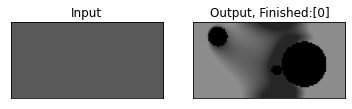

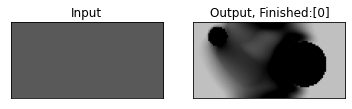

In [9]:
checkData(0)

In [10]:
Data_train, Data_test = train_test_split(Data, test_size=0.05)
print("Train: {}".format(len(Data_train)))
print("\nTest: {}".format(len(Data_test)))

Train: 2966

Test: 157


In [11]:
#universal parameters
activation = 'relu'
uniformRandomInitalizer = tf.random_uniform_initializer(minval=0.3, maxval=0.3)

In [12]:
def buildEncoder(x_inputShape = (100,50,1)):
    partInput = keras.Input(shape=x_inputShape,name="x")
    
    partInput_resize = layers.Resizing(height=128,width=64)(partInput)
    
    #First Convolution Layer
    conv_128_64 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(partInput_resize)
    conv_128_64 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(conv_128_64)

    conv_64_32 = layers.MaxPooling2D((2, 2), padding="same")(conv_128_64)
    conv_64_32 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(conv_64_32)
    conv_64_32 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(conv_64_32)

    conv_32_16 = layers.MaxPooling2D((2, 2), padding="same")(conv_64_32)

    output_part = layers.Conv2D(filters= 1, kernel_size=(1,1), padding='same', activation="hard_sigmoid", name="x_out")(conv_32_16)

    
    return keras.Model(inputs= [partInput],outputs=[output_part])

def buildDecoder(x_inputShape = (32,16,1)):
    partInput = keras.Input(shape=x_inputShape,name="x")

    conv_32_16 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(partInput)

    conv_64_32 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(conv_32_16)
    conv_64_32 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(conv_64_32)

    conv_128_64 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(conv_64_32)
    conv_128_64 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(conv_128_64)

    output_resize =layers.Resizing(height=100,width=50)(conv_128_64)
    output_part = layers.Conv2D(filters= 1, kernel_size=(1,1), padding='same', activation='hard_sigmoid', name="x_out")(output_resize)

    return keras.Model(inputs= [partInput],outputs=[output_part])

class AutoEncoder(keras.Model):
    def __init__(self):

        super(AutoEncoder, self).__init__()
        self.encoder = buildEncoder()
        self.decoder = buildDecoder()
        
    def call(self,data):
        x = self.encoder(data)
        y = self.decoder(x)
        return y







In [13]:
def SetUpOptimizer(variant):
    """
    Builds a keras optmizer based of default parameters
    
    Accepts:
        1:adam
        2:adadelta
        3:adafactor
        4:adagrad
        5:adamax
        6:ftrl
        7:nadam
        8:rmsprop
    """
    if(variant == 1 or variant == 'adam'):
        print("Optimizer: Adam")
        return keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam') 
    elif(variant == 2 or variant == 'adadelta'):
        print("Optimizer: AdaDelta")
        return keras.optimizers.experimental.Adadelta(
                                                        learning_rate=0.001,
                                                        rho=0.95,
                                                        epsilon=1e-07,
                                                        ema_momentum=0.99,
                                                        name='Adadelta'
                                                    )
    elif(variant == 3 or variant == 'adafactor'):
        print("Optimizer: AdaFactor")
        return keras.optimizers.experimental.Adafactor(
                                                        learning_rate=0.001,
                                                        beta_2_decay=-0.8,
                                                        epsilon_1=1e-30,
                                                        epsilon_2=0.001,
                                                        clip_threshold=1.0,
                                                        ema_momentum=0.99,
                                                        name='Adafactor'
                                                    )
    elif(variant == 4 or variant == 'adagrad'):
        print("Optimizer: AdaGrad")
        return keras.optimizers.experimental.Adagrad(
                                                        learning_rate=0.001,
                                                        initial_accumulator_value=0.1,
                                                        epsilon=1e-07,
                                                        ema_momentum=0.99,
                                                        name='Adagrad'
                                                    )
    elif(variant == 5 or variant == 'adamax'):
        print("Optimizer: AdaMax")
        return keras.optimizers.experimental.Adamax(
                                                        learning_rate=0.001,
                                                        beta_1=0.9,
                                                        beta_2=0.999,
                                                        epsilon=1e-07,
                                                        ema_momentum=0.99,
                                                        name='Adamax'
                                                    )
    elif(variant == 6 or variant == 'ftrl'):
        print("Optimizer: FTRL")
        return keras.optimizers.experimental.Ftrl(
                                                    learning_rate=0.001,
                                                    learning_rate_power=-0.5,
                                                    initial_accumulator_value=0.1,
                                                    l1_regularization_strength=0.0,
                                                    l2_regularization_strength=0.0,
                                                    l2_shrinkage_regularization_strength=0.0,
                                                    beta=0.0,
                                                    ema_momentum=0.99,
                                                    name='Ftrl'
                                                )
    elif(variant == 7 or variant == 'nadam'):
        print("Optimizer: Nadam")
        return keras.optimizers.experimental.Nadam(
                                                    learning_rate=0.001,
                                                    beta_1=0.9,
                                                    beta_2=0.999,
                                                    epsilon=1e-07,
                                                    ema_momentum=0.99,
                                                    name='Nadam'
                                                )
    elif(variant == 8 or variant == 'rmsprop'):
        print("Optimizer: RMSprop")
        return keras.optimizers.experimental.RMSprop(
                                                        learning_rate=0.001,
                                                        rho=0.9,
                                                        momentum=0.0,
                                                        epsilon=1e-07,
                                                        ema_momentum=0.99,
                                                        ema_overwrite_frequency=100,
                                                        name='RMSprop'
                                                    )
    else:
        print("Optimizer: Adam")
        return keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam') 

In [14]:
#setUp modelSaving

def getModel(modelNumber,optimizerVarient:int = 1,LoadWeights:bool=True):

    if(modelNumber == 9):
        model = AutoEncoder()
        fileSaveName = "Model_m9"
    else:
        raise Exception("No model identified, model {} DNE.".format(modelNumber))
    

    modelPath = os.path.join(os.getcwd(),'ModelSave',fileSaveName)
    
    cp_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(modelPath,fileSaveName),
                                                     save_weights_only=True,
                                                     verbose=1)
    if(os.path.isdir(modelPath)):
        if(LoadWeights):
            try:
                
                model.load_weights(os.path.join(modelPath,fileSaveName))
            except:
                print("Model weights could not be loaded.")
            else:
                print("Model weights Loaded")
        else:
            print("Model weights were not loaded.")
    else:
        os.mkdir(modelPath)
        print("Model path created")


    model.compile(  optimizer=SetUpOptimizer(optimizerVarient),
                    loss= keras.losses.BinaryCrossentropy()
                    )
    return model,cp_callback

In [15]:
currentModelNumber = 9 #change this one
model,callBack = getModel(currentModelNumber)#,LoadWeights=False)
print()
model.encoder.summary()
model.decoder.summary()

Model weights Loaded
Optimizer: Adam

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 100, 50, 1)]      0         
                                                                 
 resizing (Resizing)         (None, 128, 64, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 128, 64, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 64, 16)       2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 32, 32)        4640      
                       

In [16]:
def plotHistory(hist):
    fig,ax = plt.subplots(1,1)
    ax.set_title("")
    keys = hist.history.keys()
    y = np.arange(1,hist.params['epochs']+1)
    for key in keys:
        if('output' in key):
            minVal = min(hist.history[key])
            meanVal = np.mean(hist.history[key])
            maxVal = max(hist.history[key])
            if(minVal != maxVal):
                print("{}:\n\tmin:{}\n\tmean:{}\n\tmax:{}".format(key,minVal,meanVal,maxVal))
                #ax.plot(y,hist.history[key],linewidth=0.5,label=key)
        else:
            ax.plot(y,hist.history[key],label=key)
            minVal = min(hist.history[key])
            meanVal = np.mean(hist.history[key])
            maxVal = max(hist.history[key])
            print("{}:\n\tmin:{}\n\tmean:{}\n\tmax:{}".format(key,minVal,meanVal,maxVal))
    
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()

In [18]:
samples = 3000*6*6 
numEpochs = 50
BatchSize = 32 # default tensorflow batchsize
numBatches = samples // BatchSize
BatchesPerEpoch = numBatches// numEpochs
print("Pretraining model over {} epochs.\n\tnumSamples: {}\n\tnumBatches: {}\n\tBatches per Epoch:{}\n".format(numEpochs,samples,numBatches,BatchesPerEpoch))

Pretraining model over 50 epochs.
	numSamples: 108000
	numBatches: 3375
	Batches per Epoch:67



In [ ]:
def create_AutoEncoder_TrainingSet(data,extraIterations):
    x_array = []

    def addNoise(image):
        noise = np.random.normal(loc=0.5,scale=.05,size=xValtoAdd.shape)
        return np.clip(image + noise,0,1)



    for i in range(len(data)):
        x = data[i].dispenceIterationsOnly()
        #add the last completed part
        xValtoAdd = x[-1]
        x_array.append(xValtoAdd)

        #add some noise to the image to increase the training set size
        x_array.append(addNoise(xValtoAdd))

        #flip the imagesSome to add more data
        x_array.append(np.fliplr(xValtoAdd))#flip left right
        x_array.append(np.fliplr(addNoise(xValtoAdd)))
        x_array.append(np.flipud(xValtoAdd))#flip up Down
        x_array.append(np.flipud(addNoise(xValtoAdd)))


        #add optional extra parts
        choice = np.random.choice(data[i].numIterations-1,size=extraIterations,replace=False).astype('int32')
        for j in range(extraIterations):
            xValtoAdd = x[choice[j]]
            x_array.append(xValtoAdd)

            #add some noise to the image to increase the training set size
            x_array.append(addNoise(xValtoAdd))

            #flip the imagesSome to add more data
            x_array.append(np.fliplr(xValtoAdd))
            x_array.append(np.fliplr(addNoise(xValtoAdd)))
            x_array.append(np.flipud(xValtoAdd))
            x_array.append(np.flipud(addNoise(xValtoAdd)))


    x_array = np.array(x_array)

    return x_array



def AutoEncoderTraining():

    x_array = create_AutoEncoder_TrainingSet(Data_train,5)

    numEpochs = 50
    BatchSize = 32 # default tensorflow batchsize
    numBatches = len(x_array) // BatchSize
    BatchesPerEpoch = numBatches// numEpochs
    print("Training AutoEncoder over {} epochs.\n\tnumSamples: {}\n\tnumBatches: {}\n\tBatches per Epoch:{}\n".format(numEpochs,len(x_array),numBatches,BatchesPerEpoch))
    
    history1 = model.fit(
        x={'x':x_array},
        y=(x_array),
        batch_size=BatchSize,
        validation_split = 0.1,
        epochs=numEpochs,
        shuffle=True,
        steps_per_epoch = BatchesPerEpoch,
        callbacks = [callBack])
    
    return history1
    
    
h2 = AutoEncoderTraining()
plotHistory(h2)


In [16]:
def DrawModelEncodings(num):
    sequenceToStart = Data_test[num]
    #print(numImages)
    fig,ax = plt.subplots(3)


    nelx = 100
    nely = 50

    
    ImageToPredict = np.array([sequenceToStart.xPhys_array[:,:,-1]])
    PredictedImages = [ImageToPredict]

    start = time()
    
    encodedImage = model.encoder.predict({'x':ImageToPredict},verbose = 0)
    DecodedImage = model.decoder.predict({'x':encodedImage},verbose = 0)

    end = time()
    print("Encoding took {:.2f} seconds.".format(end-start))


    
    ax[0].imshow(np.reshape(ImageToPredict,(nelx,nely)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)

    ax[1].imshow(np.reshape(encodedImage,(32,16)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)

    ax[2].imshow(np.reshape(DecodedImage,(nelx,nely)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
    ax[2].get_xaxis().set_visible(False)
    ax[2].get_yaxis().set_visible(False)


    ax[0].set_title("Start")
    ax[1].set_title("Encoded")
    ax[2].set_title("Decoded")
    plt.show()


5
Encoding took 0.25 seconds.


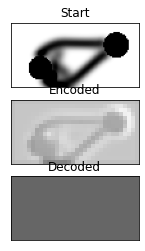

Encoding took 0.11 seconds.


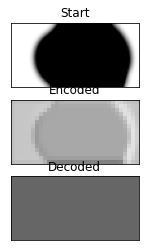

Encoding took 0.11 seconds.


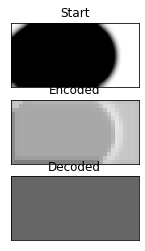

Encoding took 0.12 seconds.


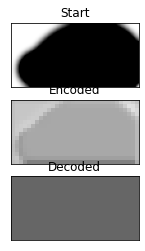

Encoding took 0.12 seconds.


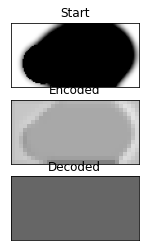

In [29]:
#n = np.random.randint(0,len(Data_test)-1)
#DrawModelEncodings(n)


n = np.arange(len(Data_test),dtype='int32')
np.random.shuffle(n)
print(len(n))
for i in range(5):
    DrawModelEncodings(n[i])